In [1]:
import zipfile
import os

zip_path = "/content/Spiral_images_Parkinson.zip"  # Update if needed
extract_dir = "/mnt/data/Spiral_images_Parkinson"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/mnt/data")

print("Extraction complete! Folder contents:")
print(os.listdir(extract_dir))


Extraction complete! Folder contents:
['valid', 'train', 'test']


In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations (resizing & normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "valid")
test_dir = os.path.join(extract_dir, "test")

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names
print("Classes:", train_dataset.classes)


Classes: ['0', '1']


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Modify last layer for binary classification (Parkinson vs Non-Parkinson)
model.fc = nn.Linear(model.fc.in_features, 2)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    return model

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)


Epoch 1/20, Train Acc: 75.42%, Val Acc: 80.33%
Epoch 2/20, Train Acc: 85.73%, Val Acc: 84.89%
Epoch 3/20, Train Acc: 88.26%, Val Acc: 87.37%
Epoch 4/20, Train Acc: 91.60%, Val Acc: 91.72%
Epoch 5/20, Train Acc: 93.28%, Val Acc: 87.99%
Epoch 6/20, Train Acc: 94.09%, Val Acc: 88.82%
Epoch 7/20, Train Acc: 96.41%, Val Acc: 88.20%
Epoch 8/20, Train Acc: 96.02%, Val Acc: 92.13%
Epoch 9/20, Train Acc: 96.55%, Val Acc: 92.13%
Epoch 10/20, Train Acc: 97.23%, Val Acc: 91.72%
Epoch 11/20, Train Acc: 98.15%, Val Acc: 92.75%
Epoch 12/20, Train Acc: 97.94%, Val Acc: 95.45%
Epoch 13/20, Train Acc: 98.51%, Val Acc: 96.27%
Epoch 14/20, Train Acc: 98.22%, Val Acc: 96.07%
Epoch 15/20, Train Acc: 99.04%, Val Acc: 95.24%
Epoch 16/20, Train Acc: 98.90%, Val Acc: 94.82%
Epoch 17/20, Train Acc: 98.04%, Val Acc: 95.65%
Epoch 18/20, Train Acc: 98.26%, Val Acc: 95.86%
Epoch 19/20, Train Acc: 98.93%, Val Acc: 95.45%
Epoch 20/20, Train Acc: 98.43%, Val Acc: 95.03%


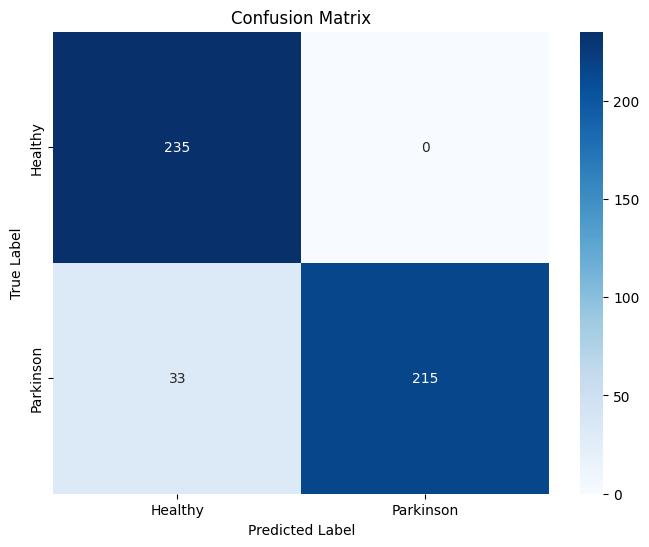

In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, val_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return all_labels, all_preds  # Return labels and predictions for classification report

# Example usage:
class_names = ['Healthy', 'Parkinson']  # Modify based on your dataset
all_labels, all_preds = plot_confusion_matrix(model, val_loader, class_names)


In [7]:
# Generate Precision, Recall, F1-score
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

     Healthy       0.88      1.00      0.93       235
   Parkinson       1.00      0.87      0.93       248

    accuracy                           0.93       483
   macro avg       0.94      0.93      0.93       483
weighted avg       0.94      0.93      0.93       483



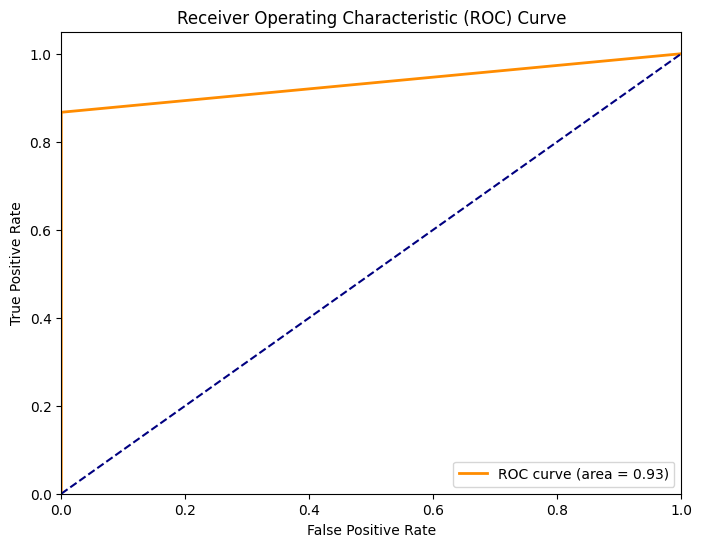

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get ROC values
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal Line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


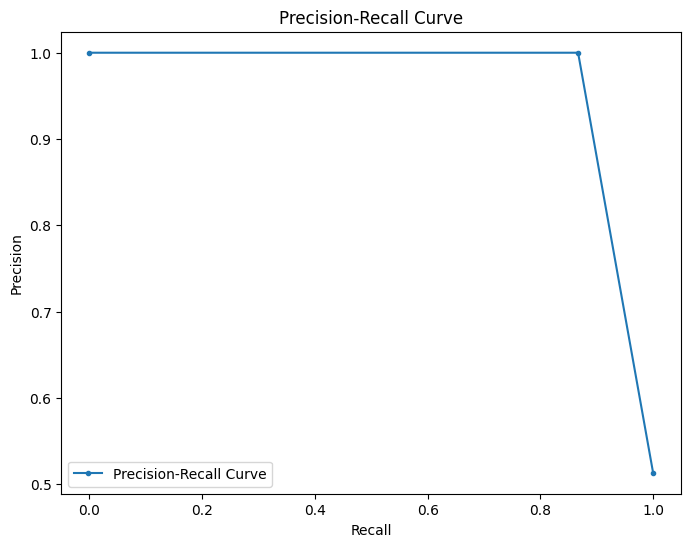

In [9]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
